## EyeFeatures: fixations complex analysis

`complex` module of the library allows to get features represented as tensors (like vectors and matrices). Look at preprocessing and features tutorial first to get grasp of simpler eyetracking attributes. Here will be shown several use-cases.

Let's take Paris dataset - it contains data about people reading texts, including eyetracking data.

In [1]:
import os
from tqdm import tqdm

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

In [2]:
def get_paris_dataset():
    '''
    Download and load the Paris experiment dataset from Zenodo.
    The dataset contains scanpaths data from 15 participants reading approximately 180 texts.
    The dataset is normalized and split into X (fixations data), Y (target), and other features.
    Deatiled description of variables and task can be found at: https://zenodo.org/records/4655840
    '''
    if not os.path.exists("data/em-y35-fasttext.csv"):
        url = "https://zenodo.org/records/4655840/files/em-y35-fasttext.csv?download=1"
        response = requests.get(url, stream=True)

        os.makedirs("data", exist_ok=True)
        with open("data/em-y35-fasttext.csv", "wb") as handle:
            for data in tqdm(response.iter_content(chunk_size=1024)):
                handle.write(data)

    df = pd.read_csv("data/em-y35-fasttext.csv")
    df.X = df.X / df.X.max()
    df.Y = df.Y / df.Y.max()
    df = df.rename(columns={'FDUR': 'duration', 'X': 'norm_pos_x', 'Y': 'norm_pos_y'})
    df['timestamp'] = df.duration.cumsum()    # timestamps of fixations
    df['timestamp'] /= 1e3                    # milliseconds

    return df.drop(columns=['Unnamed: 0'])

In [3]:
data = get_paris_dataset()
data = data[['SUBJ', 'norm_pos_x', 'norm_pos_y', 'timestamp', 'duration']]
data

,SUBJ,norm_pos_x,norm_pos_y,timestamp,duration
0,1,0.376268,0.384969,0.096,96
1,1,0.437754,0.383532,0.225,129
2,1,0.546146,0.382957,0.505,280
3,1,0.706643,0.399626,0.783,278
4,1,0.724645,0.397615,1.049,266
...,...,...,...,...,...
39559,15,0.420385,0.796091,7279.520,142
39560,15,0.536004,0.806581,7279.691,171
39561,15,0.526749,0.882885,7279.843,152
39562,15,0.757860,0.875126,7280.119,276


In [4]:
x = 'norm_pos_x'
y = 'norm_pos_y'
t = 'timestamp'

Let's pick subject #6 as an example on which we will apply `complex` module's methods.

In [5]:
data1 = data[data['SUBJ'] == 6]
len(data1)

1810

In [6]:
import eyefeatures.features.complex as eye_complex

Methods to be discussed:

1. Hilbert curve.
2. Markov Transitional Field.
3. Gramian Angular Field.

### 1. Hilbert Curve

Hilbert Curve is a way to describe 2D space using 1D object. It provides a bijection (unique mapping) of 2D plane on a 1D line, constructed as a limit of piecewise linear curves, $n$-th curve having a length of $2^n - \frac{1}{2^n}$. On practice, we fix some $p$ and consider $p$-th Hilbert Curve and map each $(x,y)$ point to the closest point on it, where higher $p$ means that more space is filled with a curve which results in more accurate encoding.

In [7]:
p = 4

In [8]:
hilbert_points = eye_complex.get_hilbert_curve(data1, x, y, scale=True, p=p)
hilbert_points

array([  8.,  11., 229., ...,  25., 226.,  33.])

Get same values as encoded feature vector (boolean encoding), where each binary value represents presence of fixations in corresponding block:

In [9]:
hilbert_points_enc = eye_complex.get_hilbert_curve_enc(data1, x, y, scale=True, p=p)
hilbert_points_enc.reshape((2 ** p, 2 ** p))

array([[0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.],
       [1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

### 2. Markov Transition Field

Given time series $X = \{x_1, .., x_n\}$, we define its quantile bins as $Q = \{q_1, ..., q_m\}$ and assign each $x_i$ with the corresponding bin $q_j$, $f: X \mapsto \{1, ..., m\}$. Then, we construct an $m\times m$ weighted adjacency matrix $W$, such that $W_{ij}$ is number of transitions from $q_i$ to $q_j$. After we normalize rows of $W$ such that $\forall i \in \{1, ..., m\}: \sum_{j=1}^{m}W_{ij} = 1$, we have $W_{ij} = P(x_k \in q_i|x_{k - 1} \in q_j)$, probability of transitioning from bin $i$ to bin $j$ in one step, which is a definition of Markov Transitional Matrix (MTM).

The problem of MTM is that it does not capture the time domain information, i.e. timestamps of $X$. Instead, define Markov Transitional Field (MTF) as a $n \times n$ matrix $M$, where $M_{ij} = W_{f(x_i), f(x_j)}$, the probability of going from bin $f(x_i)$ to bin $f(x_j)$ in $k = |i - j|$ steps.

In [10]:
mtf = eye_complex.get_mtf(data1, x, y, n_bins=20)
mtf.shape, len(data1)

((2, 1810, 1810), 1810)

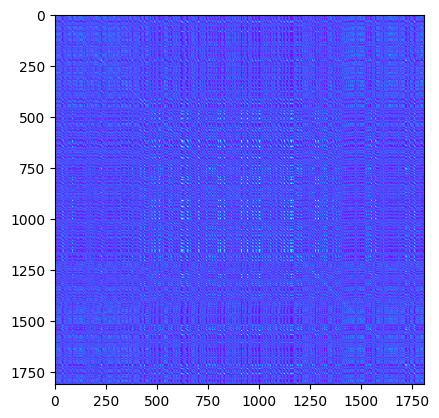

In [11]:
plt.imshow(mtf[1, :, :], cmap='rainbow');

Use max pooling to shrink output:

In [12]:
mtf_max = eye_complex.get_mtf(data1, x, y, n_bins=20, output_size=0.5, shrink_strategy='max')
mtf_max.shape, len(data1) // 2

((2, 905, 905), 905)

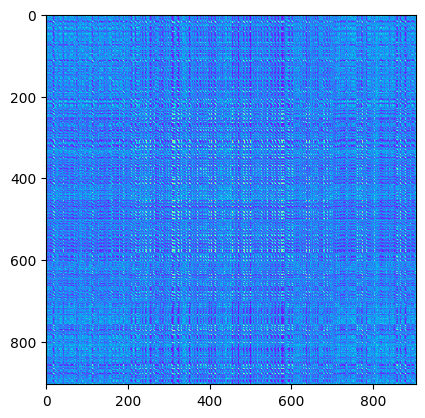

In [13]:
plt.imshow(mtf_max[1, :, :], cmap='rainbow');

### Gramian Angular Field

Given time series $X = \{x_1, ..., x_n\}$ of $n$ real-valued observations, GAF is build using the following procedure:
1. Series is rescaled to $[0, 1]$ using min-max scaling (or assumed to be already scaled, look at `scale` parameter of `get_gaf` method):

$$\tilde{x}_i = \frac{x_i - \min X}{\max X - \min X}$$

2. Scaled time series $\tilde{X}$ is converted to polar coordinates using one of two methods ($t_i$ is corresponding timestamp):

    * Trigonometric formula (`to_polar='regular'`)
    $$r_i = \sqrt{\tilde{x}_i^2 + t_i^2}, \ \phi_i = arctan\left(\frac{t_i}{\tilde{x}_i}\right)$$

    * Cosine formula (`to_polar='cosine'`)
    $$r_i = \frac{t_i}{n}, \ \phi_i = arccos(\tilde{x}_i)$$
3. Then matrix $M$ is constructed, again with one of two ways:
    * Cosine of sum (`field_type='sum'`)
    $$(M)_{ij} = \cos(\phi_i + \phi_j)$$

    * Sine of difference (`field_type='difference'`)
    $$(M)_{ij} = \sin(\phi_i - \phi_j)$$

Let's visualize the fields.


In [14]:
gasf_regular = eye_complex.get_gaf(data1, x, y, t='timestamp', field_type='sum', to_polar='regular')
gadf_regular = eye_complex.get_gaf(data1, x, y, t='timestamp', field_type='difference', to_polar='regular')
gasf_cosine = eye_complex.get_gaf(data1, x, y, t='timestamp', field_type='sum', to_polar='cosine')
gadf_cosine = eye_complex.get_gaf(data1, x, y, t='timestamp', field_type='difference', to_polar='cosine')

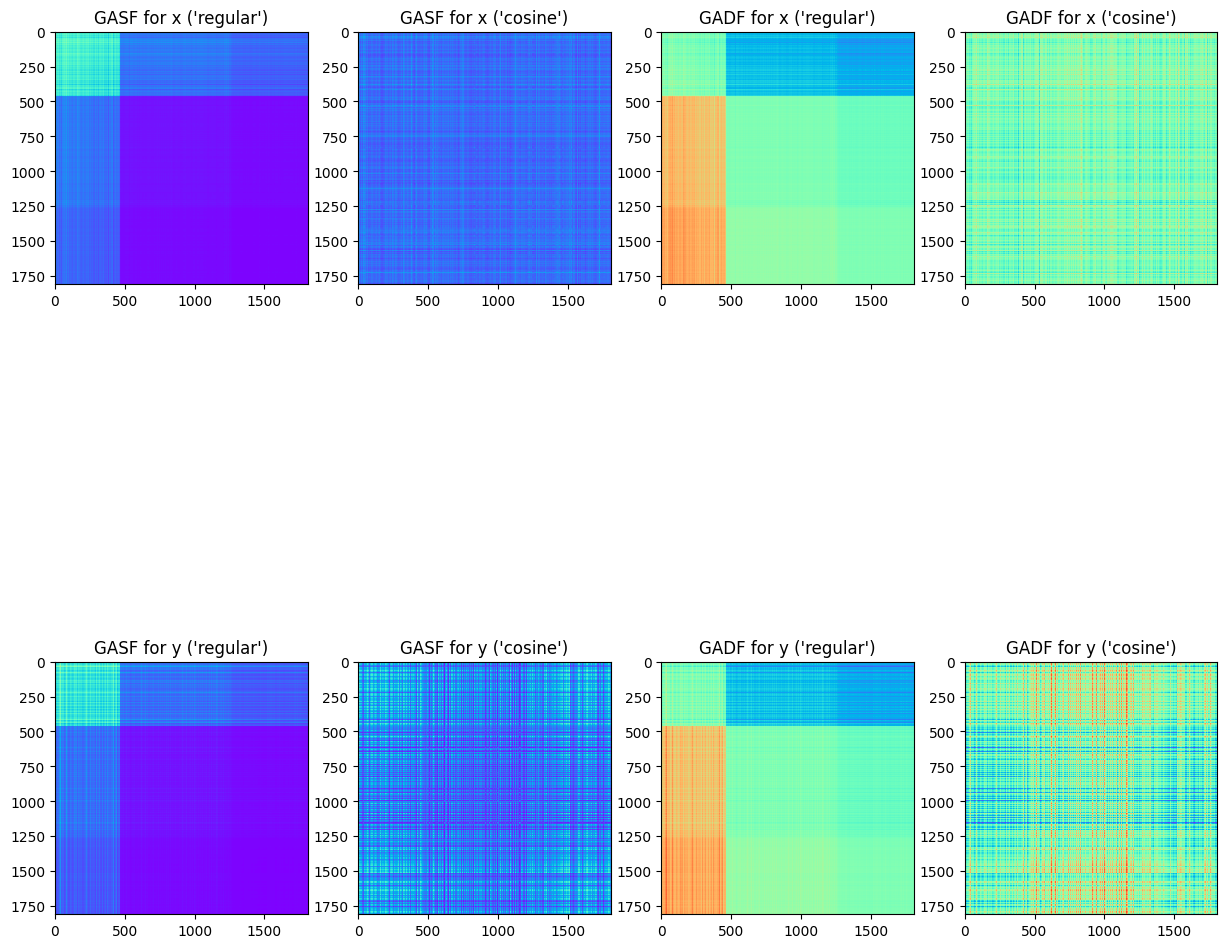

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(15, 15))
c_addon = ("for x", "for y")
t_addon = ("'regular'", "'cosine'")

for i in range(2):
    axes[i][0].imshow(gasf_regular[i], cmap='rainbow')
    axes[i][0].set(title=f"GASF {c_addon[i]} ({t_addon[0]})")
    axes[i][1].imshow(gasf_cosine[i], cmap='rainbow')
    axes[i][1].set(title=f"GASF {c_addon[i]} ({t_addon[1]})")
    axes[i][2].imshow(gadf_regular[i], cmap='rainbow')
    axes[i][2].set(title=f"GADF {c_addon[i]} ({t_addon[0]})")
    axes[i][3].imshow(gadf_cosine[i], cmap='rainbow')
    axes[i][3].set(title=f"GADF {c_addon[i]} ({t_addon[1]})")

### References

1. [Hilbert Curve](https://en.wikipedia.org/wiki/Hilbert_curve). [Hilbert Curve encoding algorithm](https://people.math.sc.edu/Burkardt/py_src/hilbert_curve/hilbert_curve.py).
2. [Zhiguang Wang & Tim Oates (2015)](https://www.researchgate.net/publication/282181246_Spatially_Encoding_Temporal_Correlations_to_Classify_Temporal_Data_Using_Convolutional_Neural_Networks). Spatial Encoding Temporal Correlations to Classify Temporal Data Using Convolutional Neural Networks. Served as a resource of MFT and GAF description.